In [104]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

class MonteCarloOptionPricing:
    def __init__(self, r, S0: float, K: float, T: float, σ: float,
                 dim: int, n: int, seed: int):
        """ Class for pricing American OptionsLSM. 
        
        Parameters: 
        S0 (float): Initial asset value
        K (float): strike price
        T (float): time to maturity, in years, a float number
        r (float): risk-free interest rate
        σ (float): volatility coefficient for diffusion
        dim (int): number of paths to simulate
        n (int): between time 0 and time T, the number of time steps 
        """
        
        assert σ >= 0, 'volatility cannot be less than zero'
        assert S0 >= 0, 'initial stock price cannot be less than zero'
        assert T >= 0, 'time to maturity cannot be less than zero'
        assert n >= 0, 'no. of slices per year cannot be less than zero'
        assert dim >= 0, 'no. of simulation paths cannot be less than zero'
        
        # Set the random seed for reproducibility
        np.random.seed(seed)
        
        self.r = r
        self.S0 = S0
        self.K = K
        self.T = T
        self.σ = σ
        self.n = n
        self.dim = dim
        self.Δ = self.T / self.n
        self.df = np.exp(-self.r*self.Δ)
        self.Z = np.random.normal(0, 1, (self.dim, self.n-1)) # white noise (drawn all at once)
        self.S = np.full((self.dim, self.n), np.nan)  # Allocate space for stock price process, with an extra step for initial value

    def GeometricBrownianMotion(self):
        """ Generate GBM paths according to Algorithm 3.
        
        Returns:
        np.ndarray: Simulated paths of the asset price.
        """
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        
        S[:,0] = np.log(S0)  # Set initial values
        for j in range(1,n):
            S[:,j] = S[:,j-1] + (r-0.5*σ**2)*Δ + σ*np.sqrt(Δ)*Z[:,j-1]
            
        self.S = np.exp(S)  # Exponentiate to get the GBM paths
        return self.S
    
    ##########################
    ### Vectorized Version ###
    ##########################
    def GeometricBrownianMotion_vec(self):
        """ Generate GBM paths according to Algorithm 3.

        Returns:
        np.ndarray: Simulated paths of the asset price.
        """

        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n

        # Generate all increments at once
        BM = (r - 0.5*σ**2)*Δ + σ*np.sqrt(Δ)*Z
        
        # Use cumsum to calculate the cumulative sum of increments and then exponentiate
        S[:,:] = np.log(S0)
        S[:,1:] += np.cumsum(BM, axis=1)

        # Multiply every path by the initial stock price
        self.S = np.exp(S)
        return self.S
    
    def MertonJumpDiffusion(self,α: float, β: float, λ: float):
        """
        Generate Merton Jump Diffusion paths according to Algorithm 4 assuming log-normal distribution of shocks.
        Parameters:
        α (float): Mean of log-normal jump size
        β (float): Volatility of log-normal jump size
        λ (float): Intensity rate of the Poisson process
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """
        self.α = α
        self.β = β
        self.λ = λ
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        α = self.α
        β = self.β
        λ = self.λ
        dim = self.dim

        S[:,0] = np.log(S0) 
        c = r - 0.5*σ**2 - λ*(np.exp(α + 0.5*β**2) - 1)
        
        # Generate Poisson and (log-)normal random jumps for all paths and time steps at once
        N = np.random.poisson(λ*Δ, (dim, n-1))  # Poisson process for the number of jumps
        Z_2 = np.random.normal(0, 1, (dim, n-1))  # Normal random variables for the jump sizes
        
        for j in range(1,n):
            # Compute jump sizes for each path
            M = α*N[:,j-1] + β*np.sqrt(N[:,j-1])*Z_2[:,j-1]
            # if no jump set jump process to zero 
            M = np.where(N[:,j-1] > 0, M, 0)
            # Calculate the combined diffusion and jump process
            S[:,j] = S[:,j-1] + c*Δ + σ*np.sqrt(Δ)*Z[:,j-1] + M
            
        self.S = np.exp(S) 
    
        return self.S
    
    ##########################
    ### Vectorized Version ###
    ##########################
    def MertonJumpDiffusion_vec(self, α: float, β: float, λ: float):
        """
        Generate Merton Jump Diffusion paths according to Algorithm 4 assuming log-normal distribution of shocks.
        Parameters:
        α (float): Mean of log-normal jump size
        β (float): Volatility of log-normal jump size
        λ (float): Intensity rate of the Poisson process
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """
        self.α = α
        self.β = β
        self.λ = λ
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        α = self.α
        β = self.β
        λ = self.λ
        dim = self.dim
        
        # No changes up to the definition of c
        c = r - 0.5*σ**2 - λ*(np.exp(α + 0.5*β**2) - 1)

        # Generate Poisson and (log-)normal random jumps for all paths and time steps at once
        N = np.random.poisson(λ*Δ, (dim, n-1))  # Poisson process for the number of jumps
        Z_2 = np.random.normal(0, 1, (dim, n-1))  # Normal random variables for the jump sizes

        # Calculate the jump sizes for all paths and time steps
        M = α * N + β*np.sqrt(N)*Z_2
        
        # if no jump set M = 0
        M = np.where(N > 0, M, 0)
        
        # Calculate the combined diffusion and jump process for all time steps
        S[:,:] = np.log(S0)
        S[:,1:] = np.log(S0) + np.cumsum(c*Δ + σ*np.sqrt(Δ)*Z + M, axis=1)

        self.S = np.exp(S)

        return self.S

    def CEV(self,γ: float):
        """
        Generate CEV paths according to Algorithm 5. 
        
        Parameters:
        γ (float): parameter governing elasticity with respect to price
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """ 
        assert γ>= 0, 'cant let elasticity be negative due to leverage effect'
        self.γ = γ

        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        γ = self.γ
        σ = self.σ
        n = self.n

        S[:,0] = S0  # Set initial values
        # Simulation using the Euler-Maruyama method for the CEV model
        for j in range(1,n):
            S[:,j] = S[:,j-1] + r*S[:,j-1]*Δ + σ*S[:,j-1]**(γ/2)*np.sqrt(Δ)*Z[:,j-1]
        self.S = S

        return self.S
    
    def BS_option_value(self, otype: str = 'put'):
        ''' Closed-form valuation of a European option in Black-Scholes.
        
        Parameters:
        otype (str): Option type either call or put (defualt: put)
        
        Returns:
        float: Option price of a European put option
        '''
        
        # unpack 
        S0 = self.S0
        K = self.K
        r = self.r
        σ = self.σ
        T = self.T

        d1 = (np.log(S0/K) + (r + 0.5*σ**2)*T) / (σ*np.sqrt(T))
        d2 = d1 - σ*np.sqrt(T)
        
        if otype == 'call':
            value = (S0 * stats.norm.cdf(d1, 0., 1.) -
                 K * np.exp(-r * T)*stats.norm.cdf(d2, 0., 1.))
        elif otype == 'put':
            value = K * np.exp(-r*T)*stats.norm.cdf(-d2) - S0*stats.norm.cdf(-d1)
        else: 
            raise ValueError('Invalid option type.')
    
        return value
    
    def american_option_LSM(self, poly_degree: int, otype: str = 'put'):
        """
        American option pricing using the LSM as outlined in Algorithm 1.
        
        Parameters:
        poly_degree (int): x^n, number of basis functions
        otype (str): call or put (default)
        
        Returns:
        float: V0, LSM Estimator
        """
        
        assert otype == 'call' or otype == 'put', 'Invalid option type.'
        assert len(self.S) != 0, 'Please simulate a stock price process.'
        # Initialize an array to store the exercise time for each path
        exercise_times = np.full(self.dim, self.n - 1)  # Start with the last time step as default

        # unpack
        S = self.S
        K = self.K
        S0 = self.S0
        n = self.n
        dim = self.dim
        df = self.df
        
        # inner values
        if otype == 'call':
            self.intrinsic_val = np.maximum(S - K, 0)
        elif otype == 'put':
            self.intrinsic_val = np.maximum(K - S, 0)
            
        # last day cashflow == last day intrinsic value
        V = np.copy(self.intrinsic_val[:,-1])

        # Backward Induction
        for i in range(n - 2, 0, -1): # start at second to last and end at second to first
            # a. find itm path 
            # (potentially) better estimate the continuation value
            itm_path = np.where(self.intrinsic_val[:,i]>0)  # evaluate: S[:,i] vs. K
            V = V * df # discount next period value
            V_itm = V[itm_path[0]] # define subset (note, we need to set [0] due to np.where being tuple)
            S_itm = S[itm_path[0],i]
            
            # b. run regression and calculate conditional expectation (LSM)
            # initialize continuation value
            C = np.zeros(shape=dim)
            # if only 5 itm paths (probably, otm options), then continuation value is zero
            if len(itm_path[0]) > 5:
                rg = np.polyfit(S_itm, V_itm, poly_degree)  # polynomial regression
                C[itm_path[0]] = np.polyval(rg, S_itm)  # evaluate conditional expectation
                    # Update exercise times
            exercise_now = self.intrinsic_val[:, i] > C
            exercise_times = np.where(exercise_now, i, exercise_times)

            # c. Calculation of value function at i 
            #if hold: V = 0, if exercise: V = intrinsic value
            V = np.where(self.intrinsic_val[:,i]>C, self.intrinsic_val[:,i], V)
        # Calculate average of discounted payoffs at exercise times
        discounted_payoffs = V * np.exp(-self.r * exercise_times * self.Δ)
        option_price = np.mean(discounted_payoffs)

        self.V0 = df*np.average(V)

        #print(f'American {otype} LSM'
        #      f'\n polynomial degree = {poly_degree} \n S0 {S0:.1f} \n K {K:.1f} \n'
        #      f'Option Value {self.V0:.3f}')

        return self.V0, exercise_times

    def plot_paths(self):
        """
        Plot simulated stock price paths along with the mean path.
        """
        # Define time interval
        time = np.linspace(0, self.T, self.n)  # Ensure to include the initial time step

        # Calculate the mean of the paths at each time step
        mean_path = np.mean(self.S, axis=0)

        # Plot
        plt.figure(figsize=(10, 6))
        
        plt.plot(time, self.S.T, lw=1, alpha=0.25)

        # Plot the mean path with a higher alpha and a different color for visibility
        plt.plot(time, mean_path, 'b', lw=2, alpha=0.75, label='Mean Path')

        plt.xlabel("Time, $t$")
        plt.ylabel("Stock Price, $S_t$")
        plt.title(f'{self.dim} Stock Price Simulation Paths')
        plt.legend()
        
        plt.show()

In [133]:
mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=36., K=40., T=1., σ=0.2, dim=2, n=50, seed=15001)
simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()
mc_option_pricing.american_option_LSM(poly_degree = 3, otype= 'put')

(4.22087765101039, array([1, 1]))

# Pricign a single option

Create an instance of the model-

In [129]:
mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=36., K=40., T=1., σ=0.2, dim=1, n=50, seed=15001)


Generate simulated paths

In [130]:
simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()

Price the American option using LSM

In [131]:
mc_option_pricing.american_option_LSM(poly_degree = 3, otype= 'put')

(5.511235542975102, array([1]))

VIsualize paths

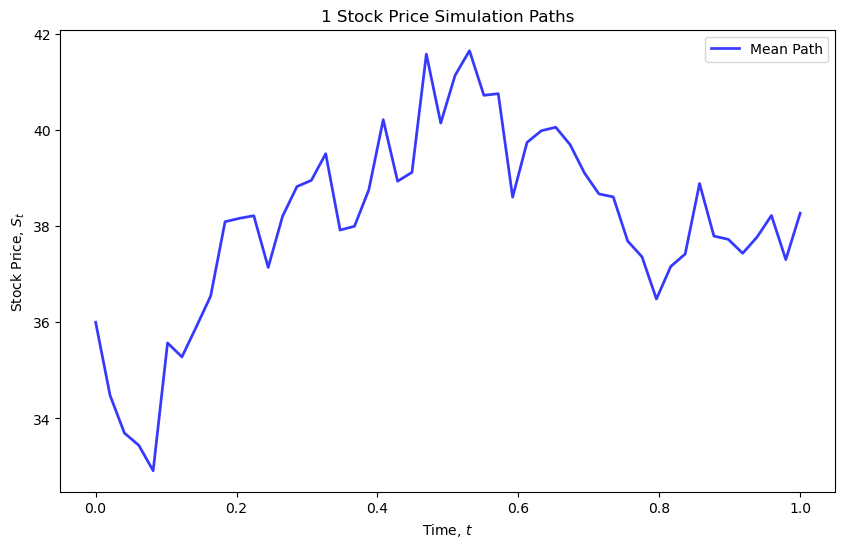

In [108]:
mc_option_pricing.plot_paths()


# Trying with a higher strike

In [109]:
mc_option_pricing_highK = MonteCarloOptionPricing(r=0.06, S0=36., K=45., T=1., σ=0.2, dim=50, n=50, seed=15001)


In [110]:
simulated_paths_highK = mc_option_pricing_highK.GeometricBrownianMotion_vec()

In [111]:
mc_option_pricing_highK.american_option_LSM(poly_degree = 3, otype= 'put')

(9.653447317209325,
 array([ 2,  3,  5,  3,  3,  2, 18,  3,  3,  1,  1,  3,  3,  3,  2,  3, 49,
         1,  3,  1,  3,  4,  3,  1,  4,  4, 10, 36,  1,  1,  3,  2,  2,  3,
         2, 11,  2, 33,  3,  2,  2,  3,  3,  3,  3,  1,  3,  2,  2,  2]))

# Pricing different options

In [126]:
# Define the parameters
strikes = [38, 40, 42, 44, 46]
maturities = [1, 2, 3]
option_prices = {}  # Dictionary to store the results

# Other parameters
r = 0.06
S0 = 46.
σ = 2
dim = 15
n = 256
seed = 15001
use_AV = True
poly_degree = 3
otype = 'put'

# Loop over strikes and maturities
for strike in strikes:
    for maturity in maturities:
        # Create an instance of the class
        mc_option_pricing = MonteCarloOptionPricing(r, S0, strike, maturity, σ, dim, n, seed)

        # Generate simulated paths
        simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()

        # Price the option
        option_price = mc_option_pricing.american_option_LSM(poly_degree, otype)

        # Store the results
        option_prices[(strike, maturity)] = option_price

        # Print the option price for the current strike and maturity
        print(f"Option Price for Strike {strike} and Maturity {maturity}: {option_price}")
        print(exercise_times)

Option Price for Strike 38 and Maturity 1: (10.873175581177888, array([  1, 230,   7,  84, 208,   9,  16, 166,   5,   3,   8, 114,   1,
         1,  15]))
[  2 251  60  10   9  15  24  11  25   2 105  87   2 251   2   1   2 200
 251   7  10  19  15  86 130  10   1 251  33  20  55   8   3  10  92  17
  22  14  35   1  10  26   9   3 104 227   2 216 251 251]
Option Price for Strike 38 and Maturity 2: (15.564788093536382, array([  1, 210,   7, 254, 179,   7, 145, 167,   5,   1,   8, 109,   1,
         1,  11]))
[  2 251  60  10   9  15  24  11  25   2 105  87   2 251   2   1   2 200
 251   7  10  19  15  86 130  10   1 251  33  20  55   8   3  10  92  17
  22  14  35   1  10  26   9   3 104 227   2 216 251 251]
Option Price for Strike 38 and Maturity 3: (16.468715386835935, array([  1, 180,   8, 253, 180,   8,  86, 162,   4,   1,   6,  81,   1,
         1,  11]))
[  2 251  60  10   9  15  24  11  25   2 105  87   2 251   2   1   2 200
 251   7  10  19  15  86 130  10   1 251  33  20  55  

# Finding the optimal exercise time for a single option

In [82]:
# Parameters used for the simulation
r = 0.02  # Risk-free rate
S0 = 48.  # Initial stock price
σ = 0.2   # Volatility
dim = 50  # Number of paths
n = 252  # Number of time steps
seed = 15001  # Seed for random number generation
poly_degree = 3  # Polynomial degree for LSM
otype = 'put'  # Option type (put or call)
strike = 40  # Example strike price
maturity = 1  # Example maturity (in years)

# Initialize the MonteCarloOptionPricing class
mc_option_pricing = MonteCarloOptionPricing(r, S0, strike, maturity, σ, dim, n, seed)
simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()

# Compute intrinsic values for each path and time step (for put options)
intrinsic_values = np.maximum(mc_option_pricing.K - simulated_paths, 0)

# Initialize an array to store the exercise time for each path
exercise_times = np.full(dim, n - 1)  # Start with the last time step

# Determine exercise times for each path
for path_index in range(dim):
    for time_step in range(n):
        if intrinsic_values[path_index, time_step] > 0:  # Simplified check
            exercise_times[path_index] = time_step
            break  # Move to the next path

# Calculate the average optimal exercise time
average_exercise_time_step = np.mean(exercise_times)

# Convert the average time step to actual time in years
average_exercise_time_in_years = average_exercise_time_step * mc_option_pricing.Δ

# Print the result
print(f"Average optimal exercise time (in years) for a {otype} option with Strike {strike}, "
      f"Maturity {maturity}, Initial Stock Price {S0}, Risk-Free Rate {r}, "
      f"Volatility {σ}, and {dim} simulation paths: {average_exercise_time_in_years:.2f} years")


Average optimal exercise time (in years) for a put option with Strike 40, Maturity 1, Initial Stock Price 48.0, Risk-Free Rate 0.02, Volatility 0.2, and 50 simulation paths: 0.80 years


# Optimal exercise time for multiple options

In [83]:
# Parameters used for the simulation
r = 0.02  # Risk-free rate
S0 = 48.  # Initial stock price
σ = 0.2   # Volatility
dim = 50  # Number of paths
n = 252  # Number of time steps
seed = 15001  # Seed for random number generation
poly_degree = 3  # Polynomial degree for LSM
otype = 'put'  # Option type (put or call)

# Define the ranges for strikes and maturities
strikes = [38, 40, 42, 44, 46]
maturities = [1, 2, 3]

# Dictionary to store the results
average_exercise_times_results = {}

# Loop over the different strikes and maturities
for strike in strikes:
    for maturity in maturities:
        # Initialize the MonteCarloOptionPricing class
        mc_option_pricing = MonteCarloOptionPricing(r, S0, strike, maturity, σ, dim, n, seed)
        simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()

        # Compute intrinsic values for each path and time step (for put options)
        intrinsic_values = np.maximum(mc_option_pricing.K - simulated_paths, 0)

        # Initialize an array to store the exercise time for each path
        exercise_times = np.full(dim, n - 1)

        # Determine exercise times for each path
        for path_index in range(dim):
            for time_step in range(n):
                if intrinsic_values[path_index, time_step] > 0:  # Simplified check
                    exercise_times[path_index] = time_step
                    break

        # Calculate the average optimal exercise time
        average_exercise_time_step = np.mean(exercise_times)

        # Convert the average time step to actual time in years
        average_exercise_time_in_years = average_exercise_time_step * mc_option_pricing.Δ

        # Store the result
        average_exercise_times_results[(strike, maturity)] = average_exercise_time_in_years

        # Print the result
        print(f"Average optimal exercise time (in years) for a {otype} option with Strike {strike}, "
              f"Maturity {maturity}, Initial Stock Price {S0}, Risk-Free Rate {r}, "
              f"Volatility {σ}, and {dim} simulation paths: {average_exercise_time_in_years:.2f} years")

# Now, average_exercise_times_results contains all the results


Average optimal exercise time (in years) for a put option with Strike 38, Maturity 1, Initial Stock Price 48.0, Risk-Free Rate 0.02, Volatility 0.2, and 50 simulation paths: 0.88 years
Average optimal exercise time (in years) for a put option with Strike 38, Maturity 2, Initial Stock Price 48.0, Risk-Free Rate 0.02, Volatility 0.2, and 50 simulation paths: 1.52 years
Average optimal exercise time (in years) for a put option with Strike 38, Maturity 3, Initial Stock Price 48.0, Risk-Free Rate 0.02, Volatility 0.2, and 50 simulation paths: 2.10 years
Average optimal exercise time (in years) for a put option with Strike 40, Maturity 1, Initial Stock Price 48.0, Risk-Free Rate 0.02, Volatility 0.2, and 50 simulation paths: 0.80 years
Average optimal exercise time (in years) for a put option with Strike 40, Maturity 2, Initial Stock Price 48.0, Risk-Free Rate 0.02, Volatility 0.2, and 50 simulation paths: 1.37 years
Average optimal exercise time (in years) for a put option with Strike 40, M

# Pricing European Put for same options with the same parameters (BLACK SCHOLES)

In [94]:
# Define the ranges for strikes and maturities
strikes = [38, 40, 42, 44, 46]
maturities = [1, 2, 3]

# Other parameters
r = 0.06
S0 = 46.
σ = 2
dim = 1
n = 252
seed = 15001
use_AV = True
poly_degree = 3
otype = 'put'

# Dictionary to store the European put option prices
european_put_prices = {}

# Loop over the different strikes and maturities for European option pricing
for strike in strikes:
    for maturity in maturities:
        # Initialize the MonteCarloOptionPricing class
        mc_option_pricing = MonteCarloOptionPricing(r, S0, strike, maturity, σ, dim, n, seed)
        
        # Calculate the European put option price
        european_put_price = mc_option_pricing.BS_option_value(otype='put')

        # Save the results in the dictionary
        european_put_prices[(strike, maturity)] = european_put_price

        # Print the European put option price
        print(f"European put option price for Strike {strike}, Maturity {maturity}, "
              f"Initial Stock Price {S0}, Risk-Free Rate {r}, Volatility {σ}: "
              f"{european_put_price:.2f}")

# Now, european_put_prices contains all the results


European put option price for Strike 38, Maturity 1, Initial Stock Price 46.0, Risk-Free Rate 0.06, Volatility 2: 22.97
European put option price for Strike 38, Maturity 2, Initial Stock Price 46.0, Risk-Free Rate 0.06, Volatility 2: 27.53
European put option price for Strike 38, Maturity 3, Initial Stock Price 46.0, Risk-Free Rate 0.06, Volatility 2: 28.57
European put option price for Strike 40, Maturity 1, Initial Stock Price 46.0, Risk-Free Rate 0.06, Volatility 2: 24.50
European put option price for Strike 40, Maturity 2, Initial Stock Price 46.0, Risk-Free Rate 0.06, Volatility 2: 29.14
European put option price for Strike 40, Maturity 3, Initial Stock Price 46.0, Risk-Free Rate 0.06, Volatility 2: 30.16
European put option price for Strike 42, Maturity 1, Initial Stock Price 46.0, Risk-Free Rate 0.06, Volatility 2: 26.04
European put option price for Strike 42, Maturity 2, Initial Stock Price 46.0, Risk-Free Rate 0.06, Volatility 2: 30.75
European put option price for Strike 42,

# One European

In [103]:
# Define the ranges for strikes and maturities
strikes = [38]
maturities = [0.88]

# Other parameters
r = 0.06
S0 = 46.
σ = 2
dim = 1
n = 252
seed = 15001
use_AV = True
poly_degree = 3
otype = 'put'

# Dictionary to store the European put option prices
european_put_prices = {}

# Loop over the different strikes and maturities for European option pricing
for strike in strikes:
    for maturity in maturities:
        # Initialize the MonteCarloOptionPricing class
        mc_option_pricing = MonteCarloOptionPricing(r, S0, strike, maturity, σ, dim, n, seed)
        
        # Calculate the European put option price
        european_put_price = mc_option_pricing.BS_option_value(otype='put')

        # Save the results in the dictionary
        european_put_prices[(strike, maturity)] = european_put_price

        # Print the European put option price
        print(f"European put option price for Strike {strike}, Maturity {maturity}, "
              f"Initial Stock Price {S0}, Risk-Free Rate {r}, Volatility {σ}: "
              f"{european_put_price:.2f}")

# Now, european_put_prices contains all the results


European put option price for Strike 38, Maturity 0.88, Initial Stock Price 46.0, Risk-Free Rate 0.06, Volatility 2: 21.93


# European Put Option sampled at exercise

In [95]:
# Dictionary to store the European put option prices using average optimal exercise times
european_put_prices_with_optimal_times = {}

# Loop over the different strikes
for strike in strikes:
    # Get the average optimal exercise times for each maturity
    for maturity in maturities:
        # Use the average optimal exercise time as the maturity for the European option
        adjusted_maturity = average_exercise_times_results[(strike, maturity)]

        # Initialize the MonteCarloOptionPricing class with the adjusted maturity
        mc_option_pricing = MonteCarloOptionPricing(r, S0, strike, adjusted_maturity, σ, dim, n, seed)
        
        # Calculate the European put option price using the adjusted maturity
        european_put_price = mc_option_pricing.BS_option_value(otype='put')

        # Save the results in the dictionary
        european_put_prices_with_optimal_times[(strike, adjusted_maturity)] = european_put_price

        # Print the European put option price
        print(f"European put option price for Strike {strike}, Adjusted Maturity {adjusted_maturity:.2f} years, "
              f"Initial Stock Price {S0}, Risk-Free Rate {r}, Volatility {σ}: "
              f"{european_put_price:.2f}")

# Now, european_put_prices_with_optimal_times contains all the results


European put option price for Strike 38, Adjusted Maturity 0.88 years, Initial Stock Price 46.0, Risk-Free Rate 0.06, Volatility 2: 21.93
European put option price for Strike 38, Adjusted Maturity 1.52 years, Initial Stock Price 46.0, Risk-Free Rate 0.06, Volatility 2: 26.03
European put option price for Strike 38, Adjusted Maturity 2.10 years, Initial Stock Price 46.0, Risk-Free Rate 0.06, Volatility 2: 27.75
European put option price for Strike 40, Adjusted Maturity 0.80 years, Initial Stock Price 46.0, Risk-Free Rate 0.06, Volatility 2: 22.61
European put option price for Strike 40, Adjusted Maturity 1.37 years, Initial Stock Price 46.0, Risk-Free Rate 0.06, Volatility 2: 26.90
European put option price for Strike 40, Adjusted Maturity 1.96 years, Initial Stock Price 46.0, Risk-Free Rate 0.06, Volatility 2: 29.04
European put option price for Strike 42, Adjusted Maturity 0.69 years, Initial Stock Price 46.0, Risk-Free Rate 0.06, Volatility 2: 22.87
European put option price for Stri

In [38]:
print(american_prices)
print(european_standard_prices_list)


[0.46249633909932275, 3.652012026865078, 5.972521968765752, 2.462337615239242, 5.651694591741548, 7.972045834974404, 4.462178891379161, 7.651377156618018, 9.971569701183057, 6.46202016751908, 9.651059721494489, 11.97109356739171, 8.461861443659, 11.650742286370958, 13.970617433600363]
[24.151426585988794, 30.077413521702287, 32.41495839341592, 25.75483004917963, 31.826329338891995, 34.20854081488268, 27.371046658437532, 33.580692397964704, 36.00479502276173, 28.99919118723009, 35.34012275477538, 37.803534070687896, 30.638470488240497, 37.10428156482821, 39.604591490615476]


# Squared correlations

In [15]:
import numpy as np

# Extract the prices into lists
american_prices = []
european_standard_prices_list = []
european_optimal_times_prices_list = []

for strike in strikes:
    for maturity in maturities:
        # American prices
        american_price = option_prices.get((strike, maturity), 0)
        american_prices.append(american_price)

        # European standard prices
        european_standard_price = european_put_prices.get((strike, maturity), 0)
        european_standard_prices_list.append(european_standard_price)

        # European optimal times prices
        adjusted_maturity = average_exercise_times_results.get((strike, maturity), 0)
        european_optimal_time_price = european_put_prices_with_optimal_times.get((strike, adjusted_maturity), 0)
        european_optimal_times_prices_list.append(european_optimal_time_price)

# Convert lists to numpy arrays for correlation computation
american_prices_array = np.array(american_prices)
european_standard_prices_array = np.array(european_standard_prices_list)
european_optimal_times_prices_array = np.array(european_optimal_times_prices_list)

# Compute the squared correlations
corr_standard = np.corrcoef(american_prices_array, european_standard_prices_array)[0, 1] ** 2
corr_optimal_times = np.corrcoef(american_prices_array, european_optimal_times_prices_array)[0, 1] ** 2

print(f"Squared Correlation between American and Standard European put options: {corr_standard:.4f}")
print(f"Squared Correlation between American and European put options at Optimal Exercise Times: {corr_optimal_times:.4f}")


Squared Correlation between American and Standard European put options: 0.8970
Squared Correlation between American and European put options at Optimal Exercise Times: 0.9406


In [16]:
# Parameters used for the simulation
r = 0.02  # Risk-free rate
S0 = 44.  # Initial stock price
σ = 0.2   # Volatility
dim = 1  # Number of paths
n = 252  # Number of time steps
seed = 150001  # Seed for random number generation
poly_degree = 3  # Polynomial degree for LSM
otype = 'put'  # Option type (put or call)

# Initialize dictionaries to store payoffs
european_payoffs_expiry = {}
european_payoffs_optimal = {}

# Loop over strikes and maturities
for strike in strikes:
    for maturity in maturities:
        # Simulate stock price paths
        mc_option_pricing = MonteCarloOptionPricing(r, S0, strike, maturity, σ, dim, n, seed)
        stock_paths = mc_option_pricing.GeometricBrownianMotion_vec()

        # Calculate American option payoff
        american_payoff = mc_option_pricing.american_option_LSM(poly_degree, otype)
        
        # Calculate European option payoff at expiry
        european_payoff_expiry = np.mean(np.maximum(strike - stock_paths[:, -1], 0))  # At final time step
        european_payoffs_expiry[(strike, maturity)] = european_payoff_expiry

        # Calculate European option payoff at optimal exercise time
        optimal_time_step = int(average_exercise_times_results[(strike, maturity)] / mc_option_pricing.Δ)
        european_payoff_optimal = np.mean(np.maximum(strike - stock_paths[:, optimal_time_step], 0))
        european_payoffs_optimal[(strike, maturity)] = european_payoff_optimal

        # Print the results
        print(f"Strike {strike}, Maturity {maturity}:")
        print(f"  American Option Payoff: {american_payoff:.2f}")
        print(f"  European Option Payoff at Expiry: {european_payoff_expiry:.2f}")
        print(f"  European Option Payoff at Optimal Time: {european_payoff_optimal:.2f}\n")


Strike 38, Maturity 1:
  American Option Payoff: 0.00
  European Option Payoff at Expiry: 0.00
  European Option Payoff at Optimal Time: 0.00

Strike 38, Maturity 2:
  American Option Payoff: 1.29
  European Option Payoff at Expiry: 0.00
  European Option Payoff at Optimal Time: 0.00

Strike 38, Maturity 3:
  American Option Payoff: 0.26
  European Option Payoff at Expiry: 0.87
  European Option Payoff at Optimal Time: 0.00

Strike 40, Maturity 1:
  American Option Payoff: 0.05
  European Option Payoff at Expiry: 0.11
  European Option Payoff at Optimal Time: 0.00

Strike 40, Maturity 2:
  American Option Payoff: 0.13
  European Option Payoff at Expiry: 1.70
  European Option Payoff at Optimal Time: 0.00

Strike 40, Maturity 3:
  American Option Payoff: 0.98
  European Option Payoff at Expiry: 2.87
  European Option Payoff at Optimal Time: 0.00

Strike 42, Maturity 1:
  American Option Payoff: 0.05
  European Option Payoff at Expiry: 2.11
  European Option Payoff at Optimal Time: 0.00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters used for the simulation
r = 0.02  # Risk-free rate
S0 = 46.  # Initial stock price
σ = 0.4   # Volatility
dim = 3  # Number of paths
n = 252  # Number of time steps
seed = 1500  # Seed for random number generation
poly_degree = 3  # Polynomial degree for LSM
otype = 'put'  # Option type (put or call)

# Initialize dictionaries to store payoffs
european_payoffs_expiry = {}
european_payoffs_optimal = {}
corr_square_expiry_dict = {}
corr_square_optimal_dict = {}

# Labels for plotting
labels = []

# Loop over strikes and maturities
for strike in strikes:
    for maturity in maturities:
        labels.append(f"{strike}/{maturity}")
        # Simulate stock price paths
        mc_option_pricing = MonteCarloOptionPricing(r, S0, strike, maturity, σ, dim, n, seed)
        stock_paths = mc_option_pricing.GeometricBrownianMotion_vec()

        # Calculate American option payoff (average across paths)
        american_payoff_avg = mc_option_pricing.american_option_LSM(poly_degree, otype)
        # Create an array of the average payoff, repeated for each path
        american_payoff_array = np.full(dim, american_payoff_avg)
        
        # Calculate European option payoff at expiry
        european_payoff_expiry = np.maximum(strike - stock_paths[:, -1], 0)
        european_payoffs_expiry[(strike, maturity)] = european_payoff_expiry

        # Calculate European option payoff at optimal exercise time
        optimal_time_step = int(average_exercise_times_results[(strike, maturity)] / mc_option_pricing.Δ)
        european_payoff_optimal = np.maximum(strike - stock_paths[:, optimal_time_step], 0)
        european_payoffs_optimal[(strike, maturity)] = european_payoff_optimal

        # Calculate squared correlations for this combination
        corr_square_expiry = np.corrcoef(american_payoff_array, european_payoff_expiry)[0, 1] ** 2
        corr_square_optimal = np.corrcoef(american_payoff_array, european_payoff_optimal)[0, 1] ** 2
        corr_square_expiry_dict[f"{strike}/{maturity}"] = corr_square_expiry
        corr_square_optimal_dict[f"{strike}/{maturity}"] = corr_square_optimal
        
        # Check if there is variability in the data before calculating correlation
        if np.std(american_payoff_array) > 0 and np.std(european_payoff_expiry) > 0:
            corr_square_expiry = np.corrcoef(american_payoff_array, european_payoff_expiry)[0, 1] ** 2
        else:
            corr_square_expiry = 0  # or np.nan, if you prefer to indicate no calculation was possible

        if np.std(american_payoff_array) > 0 and np.std(european_payoff_optimal) > 0:
            corr_square_optimal = np.corrcoef(american_payoff_array, european_payoff_optimal)[0, 1] ** 2
        else:
            corr_square_optimal = 0  # or np.nan

        # Print the results
        print(f"Strike {strike}, Maturity {maturity}:")
        print(f"  American Option Payoff: {american_payoff_avg:.2f}")
        print(f"  European Option Payoff at Expiry: {np.mean(european_payoff_expiry):.2f}")
        print(f"  European Option Payoff at Optimal Time: {np.mean(european_payoff_optimal):.2f}")
        print(f"  Squared Correlation at Expiry: {corr_square_expiry:.4f}")
        print(f"  Squared Correlation at Optimal Time: {corr_square_optimal:.4f}\n")

# Plotting the results
plt.figure(figsize=(10, 6))
x = range(len(labels))  # x-axis positions
plt.scatter(x, list(corr_square_expiry_dict.values()), color='blue', label='American vs European at Expiry')
plt.scatter(x, list(corr_square_optimal_dict.values()), color='red', label='American vs European at Optimal')

# Adding labels and title
plt.xticks(x, labels, rotation=45)
plt.xlabel('Strike/Maturity')
plt.ylabel('Squared Correlation')
plt.title('Squared Correlation between American and European Put Options')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

# Extract the payoffs into arrays
american_payoffs = np.array([european_payoffs_optimal[(strike, maturity)] for strike in strikes for maturity in maturities])
european_payoffs_expiry_array = np.array([european_payoffs_expiry[(strike, maturity)] for strike in strikes for maturity in maturities])
european_payoffs_optimal_array = np.array([european_payoffs_optimal[(strike, maturity)] for strike in strikes for maturity in maturities])

# Calculate the squared correlations
corr_square_expiry = np.corrcoef(american_payoffs, european_payoffs_expiry_array)[0, 1] ** 2
corr_square_optimal = np.corrcoef(american_payoffs, european_payoffs_optimal_array)[0, 1] ** 2

# Print the results
print(f"Squared Correlation between American and European (at expiry) option payoffs: {corr_square_expiry:.4f}")
print(f"Squared Correlation between American and European (at optimal time) option payoffs: {corr_square_optimal:.4f}")


In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store squared correlations
corr_standard_list = []
corr_optimal_times_list = []
parameter_labels = []

# Calculate squared correlations for each strike/maturity pair
for strike in strikes:
    for maturity in maturities:
        parameter_labels.append(f"{strike}/{maturity}")

        # Get prices
        american_price = option_prices.get((strike, maturity), 0)

        european_standard_price = european_put_prices.get((strike, maturity), 0)
        adjusted_maturity = average_exercise_times_results.get((strike, maturity), 0)
        european_optimal_time_price = european_put_prices_with_optimal_times.get((strike, adjusted_maturity), 0)

        # Calculate squared correlations
        corr_standard = np.corrcoef([american_price], [european_standard_price])[0, 1] ** 2
        corr_optimal_times = np.corrcoef([american_price], [european_optimal_time_price])[0, 1] ** 2

        corr_standard_list.append(corr_standard)
        corr_optimal_times_list.append(corr_optimal_times)

# Plotting
plt.figure(figsize=(10, 6))
x = range(len(parameter_labels))  # x-axis positions

plt.scatter(x, corr_standard_list, color='blue', label='American vs Standard European')
plt.scatter(x, corr_optimal_times_list, color='red', label='American vs European at Optimal Times')

# Adding labels and title
plt.xticks(x, parameter_labels, rotation=45)
plt.xlabel('Strike/Maturity')
plt.ylabel('Squared Correlation')
plt.title('Squared Correlation between American and European Put Options')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of paths to display
num_paths_to_display = 10

# Select a few paths
selected_paths = mc_option_pricing.S[:num_paths_to_display]

# Time points for plotting
time_points = np.linspace(0, maturity, n)

# Plot the selected paths and their intrinsic values
plt.figure(figsize=(15, 7))

for path in selected_paths:
    plt.plot(time_points, path, label='Stock Price Path')
    plt.plot(time_points, np.maximum(mc_option_pricing.K - path, 0), label='Intrinsic Value', linestyle='--')

plt.xlabel('Time (Years)')
plt.ylabel('Price/Intrinsic Value')
plt.title(f'Sample Paths and Intrinsic Values for a Put Option with Strike {mc_option_pricing.K}')
plt.legend()
plt.show()
